# MovingMNIST LSTMConv2D Example
Adapted from [github: TensorFlow Examples](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/recurrent_network.ipynb).

Uses a custom LSTM cell that implements the LSTMConv2D op like in Keras. Also, uses an on-the-fly generated MovingMNIST dataset, adapted by [Unsupervised Learning with LSTMs](https://github.com/emansim/unsupervised-videos).

In [1]:
# Force matplotlib to use inline rendering
%matplotlib inline

from __future__ import print_function

import os
import sys

# add path to libraries for ipython
sys.path.append(os.path.expanduser("~/libs"))

import random

import numpy as np
import tensorflow as tf
import tensortools as tt

In [2]:
BATCH_SIZE = 24

MAX_STEPS = 500
DISPLAY_STEPS = 10
VALID_STEPS = 100


LEARGNING_RATE = 5e-4

TIME_STEPS_IN = 10
PREDICTION_STEPS = 1  # this value is more or less hard coded
KERNEL_FILTERS = 64
KERNEL_SIZE = 5
IMAGE_SIZE = 64
CHANNELS = 1

LSTM_LAYERS = 2

REG_LAMBDA = 5e-4

MEMORY_DEVICE = '/cpu:0'

### Input data

In [3]:
dataset_train = tt.datasets.moving_mnist.MovingMNISTTrainDataset(input_shape=[TIME_STEPS_IN, 64, 64, 1],
                                                                 target_shape=[PREDICTION_STEPS, 64, 64, 1])
dataset_valid = tt.datasets.moving_mnist.MovingMNISTValidDataset(input_shape=[TIME_STEPS_IN, 64, 64, 1],
                                                                 target_shape=[PREDICTION_STEPS, 64, 64, 1])
dataset_test = tt.datasets.moving_mnist.MovingMNISTTestDataset(input_seq_length=TIME_STEPS_IN,
                                                               target_seq_length=PREDICTION_STEPS)

File mnist.h5 has already been downloaded.
File mnist.h5 has already been downloaded.


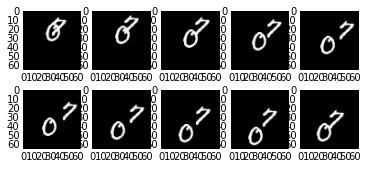

In [6]:
bx, by = dataset_train.get_batch(BATCH_SIZE)

# visualize the first sequence
tt.visualization.display_batch(bx[0,:,:,:,:] * 255, nrows=3, ncols=5)

### Graph construction

In [11]:
g = tf.Graph()

In [12]:
def RNN(x):
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2, 3, 4])
    # Split to get a list of 'n_steps'
    x = tf.split(0, TIME_STEPS_IN, x)
    x = [tf.squeeze(i, (0,)) for i in x]

    # Define a lstm cell with tensorflow
    lstm_cell = tt.recurrent.BasicLSTMConv2DCell(IMAGE_SIZE, IMAGE_SIZE,
                                                 KERNEL_FILTERS,
                                                 ksize_input=(KERNEL_SIZE, KERNEL_SIZE), 
                                                 ksize_hidden=(KERNEL_SIZE, KERNEL_SIZE), 
                                                 forget_bias=1.0,
                                                 hidden_activation=tt.network.hard_sigmoid,
                                                 device=MEMORY_DEVICE)
    if LSTM_LAYERS > 1:
        lstm_cell = tt.recurrent.MultiRNNConv2DCell([lstm_cell] * LSTM_LAYERS,
                                                    state_is_tuple=True)
    # Get lstm cell output
    outputs, states = tt.recurrent.rnn_conv2d(lstm_cell, x)

    # Linear activation, using rnn inner loop last output
    return outputs[-1]

In [13]:
with g.as_default():
    x = tf.placeholder(tf.float32, [None, TIME_STEPS_IN, IMAGE_SIZE, IMAGE_SIZE, CHANNELS], "X")
    y_ = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS], "Y_")

    # image to value scale [-1,1] (roughly zero mean)
    x = x * 2 - 1
    
    out = RNN(x)
    
    # 1x1 convolution
    pred = tt.network.conv2d_transpose("Deconv", out, 1,
                             (KERNEL_SIZE, KERNEL_SIZE), (1, 1),
                             regularizer=tf.contrib.layers.l2_regularizer(REG_LAMBDA),
                             device=MEMORY_DEVICE)
    
    # convert back to value scale [0,1]
    pred = (pred + 1) / 2

In [14]:
with g.as_default():
    with tf.name_scope("Train"):
        loss_l2 = tf.nn.l2_loss(pred - y_) / BATCH_SIZE
        loss_l1 = tf.reduce_sum(tf.abs(pred - y_)) / BATCH_SIZE
        
        reg_loss = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES), name="reg_loss")
        total_loss = tf.add(loss_l2, reg_loss, name="total_loss")
        
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARGNING_RATE).minimize(total_loss)

### Training

In [18]:
with g.as_default():
    # Launch the graph
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
    
    sess.run(tf.initialize_all_variables())

    tt.visualization.show_graph(sess.graph_def)

    dataset_train.reset()
    
    step = 1
    # Keep training until reach max iterations
    while step <= MAX_STEPS:
        batch_x, batch_y = dataset_train.get_batch(BATCH_SIZE) 
        batch_y = batch_y[:,0,:,:,:]
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y_: batch_y})
        if step % DISPLAY_STEPS == 0:
            # Calculate batch loss
            l1, l2 = sess.run([loss_l1, loss_l2], feed_dict={x: batch_x, y_: batch_y})
            print("@{}/{}: Minibatch Train Loss-L2= {:.6f} (Train Loss-L1= {:.6f})".format(
                    step, MAX_STEPS,
                    l2, l1))
        if step % VALID_STEPS == 0:
            dataset_valid.reset()
            num_batches = dataset_valid.dataset_size // dataset_valid.batch_size
            loss_sum = 0
            for b in xrange(num_batches):
                batch_x, batch_y = dataset_valid.get_batch(BATCH_SIZE)
                batch_y = batch_y[:,0,:,:,:]

                l2 = sess.run(loss_l2, feed_dict={x: batch_x, y_: batch_y})
                loss_sum += l2 / PREDICTION_STEPS
            
            avg_loss_per_frame = loss_sum / num_batches
            print("@{}: Minibatch Avg. Valid Loss-L2 per Frame= {:.6f}".format(
                    step, avg_loss_per_frame))

        step += 1
    print("Optimization Finished!")

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f6b92974fd0>> ignored


ResourceExhaustedError: OOM when allocating tensor with shape[24,64,64,64]
	 [[Node: RNNConv2D/MultiRNNConv2DCell_9/Cell0/BasicLSTMConv2DCell/Conv_xj/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Squeeze_9, RNNConv2D/MultiRNNConv2DCell/Cell0/BasicLSTMConv2DCell/Conv_xj/W/read/_19)]]
	 [[Node: Train/gradients/AddN_51/_423 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_13214_Train/gradients/AddN_51", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'RNNConv2D/MultiRNNConv2DCell_9/Cell0/BasicLSTMConv2DCell/Conv_xj/Conv2D', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 498, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-7d6489f68c71>", line 8, in <module>
    out = RNN(x)
  File "<ipython-input-12-b16ce5d6a332>", line 20, in RNN
    outputs, states = tt.recurrent.rnn_conv2d(lstm_cell, x)
  File "/usr/stud/sauterme/libs/tensortools/recurrent.py", line 133, in rnn_conv2d
    (output, state) = call_cell()
  File "/usr/stud/sauterme/libs/tensortools/recurrent.py", line 120, in <lambda>
    call_cell = lambda: cell(input_, state)
  File "/usr/stud/sauterme/libs/tensortools/recurrent.py", line 506, in __call__
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "/usr/stud/sauterme/libs/tensortools/recurrent.py", line 417, in __call__
    device=self._device)
  File "/usr/stud/sauterme/libs/tensortools/network.py", line 161, in conv2d
    x, w, strides=[1, stride[0], stride[1], 1], padding=padding)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 394, in conv2d
    data_format=data_format, name=name)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/stud/sauterme/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


### Testing

In [ ]:
with g.as_default():
    batch_x, batch_y = dataset_test.get_batch(BATCH_SIZE)
    batch_y = batch_y[:,0,:,:,:]
    
    # remove batch_dim
    batch_x = batch_x[0,:,:,:,:]
    batch_y = batch_y[0,:,:,:] 
    loss_factor = BATCH_SIZE
    
    print('IN:')
    for i in range(TIME_STEPS_IN):
        tt.visualization.display_array(batch_x[i] * 255)
        
    print('TARGET:')
    tt.visualization.display_array(batch_y * 255)
    
    print('PREDICTION:')
    batch_x = np.expand_dims(batch_x, axis=0)
    batch_y = np.expand_dims(batch_y, axis=0)
    prediction, l1, l2 = sess.run([pred, loss_l1, loss_l2], feed_dict={x: batch_x, y_: batch_y})
    prediction_squeezed = np.squeeze(prediction, axis=0)
    prediction_scaled = prediction_squeezed * 255
    tt.visualization.display_array(prediction_scaled)
    
    print('PREDICTION (fixed):')
    np.place(prediction_squeezed, prediction_squeezed > 1, [1])
    np.place(prediction_squeezed, prediction_squeezed < 0, [0])
    prediction_scaled = prediction_squeezed * 255
    tt.visualization.display_array(prediction_scaled)
    
    print('min-value: ', np.min(prediction_scaled))
    print('max-value: ', np.max(prediction_scaled))
    print('Test l1-loss:', l1 * loss_factor)
    print('Test l2-loss:', l2 * loss_factor)

In [ ]:
with g.as_default():
    dataset_test.reset()
    num_batches = dataset_test.dataset_size // dataset_valid.batch_size
    print(num_batches)
    loss_sum = 0
    for b in xrange(num_batches):
        batch_x, batch_y = dataset_valid.get_batch(BATCH_SIZE)
        batch_y = batch_y[:,0,:,:,:]
        
        l2 = sess.run(loss_l2, feed_dict={x: batch_x, y_: batch_y})
        loss_sum += l2 / PREDICTION_STEPS

    avg_loss_per_frame = loss_sum / num_batches
    print("Avg. Test Loss-L2 per Frame= {:.6f}".format(avg_loss_per_frame))